# Hypothèses de travail

- On a un graphe de connexion au niveau de la passerelle

On connait au moins les noeuds mais on ne connait pas forcement les arêtes (route ou bien lien radios) entre les noeuds.

- Cette information est juste indispensable pour connaitre les impacts de restrictions de traffic via le cache sur l'ensemble des noeuds.

,e_0,c_min,c_max,lambda_r
nodes,,,,
0,100,1,9,1
1,100,1,9,1
2,100,1,9,1
3,100,1,9,1
4,100,1,9,1
5,100,1,9,1
6,100,1,9,1


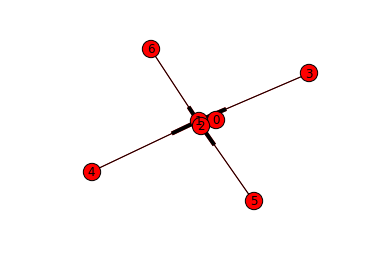

In [2]:
import pandas as pd
import random
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

# Tree structure
g = nx.balanced_tree(2, 2)
g = nx.convert.convert_to_directed(g)
for a, b in g.edges():
    if a < b:
        g.remove_edge(a, b)

# Graph drawing
pos = nx.spring_layout(g)
nx.draw_networkx_labels(g, pos=pos)
nx.draw_networkx_edges(g, pos, edge_color='r', arrows=True)

# We add attributes to nodes (they could be random)
g.add_nodes_from([(node_id, {
                "e_0": 100, 
                "c_min": 1,
                "lambda_r": 1,
                "c_max": 9}) for node_id in g.nodes()])

N = len(g.nodes())

# For ease of manipulation we make a table
df = pd.DataFrame(index=pd.Index(g.nodes(), name="nodes"))
for attribute in ["e_0", "c_min", "c_max", "lambda_r"]:
    temp = nx.get_node_attributes(g, attribute)
    temp_df = pd.DataFrame.from_dict(temp, orient="index").rename(columns={0: attribute})
    df = df.join(temp_df)

#df = df_to_merge[0].join(df_to_merge[1:])

# Drawing
nx.draw(g, pos=pos)  # You need %matplotlib inline to see it in the notebook

# DataFrame
df

- $E_0$: is the budget of energy that the node got. $E = 0$ means that the node is dead.

- $c_{min}$: Minimal cache time. It would not be relevant to have a $c$ lower than this value.

- $c_{max}$: Maximal cache time. It would not be relevant to have a $c$ higher than this value.

In [3]:
def impact_matrix(g):
    """
    Will compute the impact matrix of the graph g.
    
    The impact matrix takes into account the forwarding
    of each-nodes in a multi-hop setup.
    
    Let A be the adjacency matrix of $G$.
    Because $A$ is nilpotente (we got a tree), $Id - A$ is inversible
    therefore we have $(Id - A)^{-1} = Id + A + A^2 + ...$
    """
    nodes = sorted(g.nodes())
    n = len(nodes)
    adj_matrix = nx.adjacency_matrix(g, nodelist=nodes).T
    return ((np.identity(n) - adj_matrix) ** (-1))

# 1 request on node 5 => one forward on node 0, 2 and 5
impact_matrix(g) * np.array([0, 0, 0, 0, 0, 1, 0]).reshape((7,1))

matrix([[ 1.],
        [ 0.],
        [ 1.],
        [ 0.],
        [ 0.],
        [ 1.],
        [ 0.]])

## Optimisation multi-objectifs

In [4]:
def ratio(c, t):
    if t <= c:
        return np.ceil(c / t) * t
    else:
        return t
rfunc = np.vectorize(ratio)

### Définition de la durée de vie du réseau

C'est dans cette fonction que l'on va utiliser la topologie du réseau ainsi que la durée de cache pour calculer une durée de vie

In [5]:
import numpy as np

# Settings

Vdd = 3
I_tx = 11.6e-3
I_sleep = 80e-9
I_idle = 396e-6
I_rx = 12.7e-3
I_sleep_idle = 691e-12
I_idle_tx = 6.63e-6
I_idle_rx = 6.63e-6
P_tx = I_tx * Vdd
P_sleep = I_sleep * Vdd
P_idle = I_idle * Vdd
P_rx = I_rx * Vdd

Energy = Vdd * 3 * 3600

# Communications settings

R = 250000
L_get = 87 * 8
L_Ans = 96 * 8
S_get = L_get / R
S_Ans = L_Ans / R
S_ack = 0.608e-3
S_get_Rxtx = S_ack
S_Ans_Rxtx = S_ack
T_period = 0.244
T_d = 0.16e-3
T_p = 0.4e-3

t_act = 4e-4
t_sleep = T_period - t_act

S_get_Rxrx = (3 * S_get) / 2 + T_p
S_Ans_Rxrx = (3 * S_Ans) / 2 + T_p
S_Ans_Txrx = (3 + np.floor((t_sleep - S_Ans) / S_Ans)) * T_d / 2 + S_ack
S_get_Txrx = (3 + np.floor((t_sleep - S_get) / S_get)) * T_d / 2 + S_ack
S_Ans_Txtx = (3 + np.floor((t_sleep - S_Ans) / S_Ans)) * S_Ans / 2
S_get_Txtx = (3 + np.floor((t_sleep - S_get) / S_get)) * S_get / 2

gamma_rx_get = P_sleep * (3 * S_get / 2 + T_p + S_ack) / T_period
gamma_rx_Ans = P_sleep * (3 * S_Ans / 2 + T_p + S_ack) / T_period
gamma_tx_get = P_sleep * ((3 + np.floor((t_sleep-S_get)/S_get))/2*(S_get+T_d) + S_ack) / T_period
gamma_tx_Ans = P_sleep * ((3 + np.floor((t_sleep-S_Ans)/S_Ans))/2*(S_Ans+T_d) + S_ack) / T_period

omega_sleep = P_sleep * t_sleep / T_period\
                - gamma_tx_Ans - gamma_rx_Ans\
                - gamma_rx_get - gamma_tx_get 
omega_cl = t_act * P_rx / T_period

mat = impact_matrix(g)

def lifetime(g, c, lambda_r):
    """
    Each omega variable will be a vector containing the related
    value for the node $i$ at index $i$.
    """   
    # Attention au cas de la racine ou l = 0
    r = rfunc(c, lambda_r)
    
    N = len(g.nodes())

    omega_CoAP_rx = (P_tx * S_get_Rxrx + P_rx * S_get_Rxtx) / r
    omega_CoAP_tx = (P_tx * S_Ans_Txtx + P_rx * S_Ans_Txrx) / r
    
    # On calcule les couts de retransmission en utilisant la matrice d'impact
    omega_forward_rx = mat.dot(omega_CoAP_rx)
    omega_forward_tx = mat.dot(omega_CoAP_tx)
    
    omega_tot = omega_sleep + omega_cl\
                + omega_CoAP_tx + omega_CoAP_rx\
                + omega_forward_rx\
                + omega_forward_tx
        
    return np.amin(df.e_0.values / omega_tot)

In [6]:
def satisfaction(c, cmax=None, cmin=None):
    if cmax is None:
        cmax = df.c_max
    if cmin is None:
        cmin = df.c_min
    return (cmax - c) / (cmax - cmin)

### Méthode d'évaluation

C'est cette méthode qui va dire à quel point notre individu est adapté. On transforme
un génotype en un phénotype et nous le jugeons.

In [7]:
c = np.random.uniform(1, 9, len(g.nodes()))
max_lifetime = lifetime(g, df.c_min, df.lambda_r)

def fitness(c):
    cmin, cmax = df.c_min, df.c_max
    mean_satisfaction = np.mean(satisfaction(c, cmin=cmin, cmax=cmax))
    life = lifetime(g, c, df.lambda_r) / (24 * 3600)
    lifetime_norm = life / max_lifetime
    return (mean_satisfaction, lifetime_norm)

c, lifetime(g, c, df.lambda_r), fitness(c)

(array([ 3.04260486,  1.38464998,  5.98633619,  6.08548781,  1.36239411,
         8.84075144,  5.26316716]),
 9955.9985323065612,
 (0.5541894364010379, 4.4156170348399675e-05))

In [9]:
from deap import creator
from deap.base import Toolbox, Fitness
from deap.tools import selNSGA2, mutPolynomialBounded, cxSimulatedBinaryBounded
from deap.tools import initRepeat, initIterate, Statistics, emo
from deap.algorithms import eaSimple, eaMuPlusLambda
from operator import attrgetter
from copy import deepcopy

creator.create("FitnessMax", Fitness, weights=(1.0, 1.0))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = Toolbox()

def uniform(low, up, size=None):
    return [random.uniform(a, b) for a, b in zip(low, up)]
toolbox.register("attr_float", uniform, df.c_min.tolist(), df.c_max.tolist())
toolbox.register("individual", initIterate, creator.Individual, toolbox.attr_float)
toolbox.register("population", initRepeat, list, toolbox.individual)

# Evaluation fonction
toolbox.register("evaluate", fitness)

# On utilise la même méthode de sélection que dans le papier
toolbox.register("select", selNSGA2)

# Executes a simulated binary crossover that modify in-place the input individuals.
# The simulated binary crossover expects sequence individuals of floating point numbers.
toolbox.register("mate", cxSimulatedBinaryBounded, 
                 low=df.c_min.tolist(), up=df.c_max.tolist(), 
                 eta=10)

toolbox.cx_prob = 0.9

# Mutation classique en NSGA2
toolbox.register("mutate", mutPolynomialBounded, 
                 low=df.c_min.tolist(), up=df.c_max.tolist(), 
                 eta=20.0, indpb=1.0/N)

# Mutation probability
toolbox.mut_prob = 0.5

fit_stats = Statistics(key=attrgetter("fitness.values"))
fit_stats.register('mean', np.mean)
fit_stats.register('min', np.min)
fit_stats.register('max', np.max)
#fit_stats.register("pop", deepcopy)

toolbox.pop_size = 500
toolbox.ngen = 50
pop = toolbox.population(n=toolbox.pop_size)

# This is just to assign the crowding distance to the individuals
# no actual selection is done
pop = toolbox.select(pop, len(pop))

result, logs = eaMuPlusLambda(pop, toolbox, ngen=toolbox.ngen,
                              lambda_=toolbox.pop_size, mu=toolbox.pop_size, 
                              cxpb=1 - toolbox.mut_prob, mutpb=toolbox.mut_prob, 
                              verbose=True, stats=fit_stats)
df_genetic = pd.DataFrame([{
                "c": x,
                "satisfaction": np.mean(satisfaction(x)),
                "lifetime": lifetime(g, x, df.lambda_r),
                "method": "genetic"
            }

                     for x in result if not any(np.isnan(x))])

gen	nevals	mean    	min        	max     
0  	500   	0.251915	2.81349e-05	0.841457
1  	500   	0.264766	2.81349e-05	0.847809
2  	500   	0.263037	2.71732e-05	0.847809
3  	500   	0.259826	2.5788e-05 	0.887526
4  	500   	0.257943	2.5788e-05 	0.887526
5  	500   	0.253673	2.5788e-05 	0.887526
6  	500   	0.251784	2.5788e-05 	0.889295
7  	500   	0.256708	2.5788e-05 	0.890471
8  	500   	0.262696	2.5788e-05 	0.890731
9  	500   	0.26236 	2.5788e-05 	0.892744
10 	500   	0.262137	2.5788e-05 	0.898531
11 	500   	0.266949	2.5788e-05 	0.905708
12 	500   	0.266601	2.5788e-05 	0.905708
13 	500   	0.263718	2.5788e-05 	0.905708
14 	500   	0.264942	2.5788e-05 	0.905708
15 	500   	0.263325	2.5788e-05 	0.905708
16 	500   	0.263616	2.5788e-05 	0.905708
17 	500   	0.267265	2.5788e-05 	0.918113
18 	500   	0.277292	2.5788e-05 	0.918113
19 	500   	0.271225	2.5204e-05 	0.918113
20 	500   	0.266601	2.5788e-05 	0.919566
21 	500   	0.277469	2.5788e-05 	0.92228 
22 	500   	0.273355	2.5204e-05 	0.924303
23 	500   	0.272

/home/sieben/.local/lib/python3.4/site-packages/deap-1.1.0-py3.4-linux-x86_64.egg/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/sieben/.local/lib/python3.4/site-packages/deap-1.1.0-py3.4-linux-x86_64.egg/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


In [ ]:
plots = plt.plot(#logs.select('min'),'c-', 
                 logs.select('mean'), 'b-',
                 logs.select('max'), 'r-', antialiased=True)
plt.legend(plots, (#'Minimum fitness',
        'Mean fitness', 'Max fitness'), loc="upper left")
plt.ylabel('Fitness')
plt.xlabel('Iterations')

## Solutions found using systematic sieve

In [11]:
numbers = [np.binary_repr(i, width=N) for i in np.arange(2**(N))]

def f(x):
    res = []
    for i in x:
        solution = np.zeros(N)
        for ind, letter in enumerate(i):
            if letter == "0":
                solution[ind] = df.c_min[ind]
            else:
                solution[ind] = df.c_max[ind]
        res.append(solution)
    return res
extremes = f(numbers)

results = [{"c": point,
            "lifetime": lifetime(g, point, df.lambda_r),
            "satisfaction": np.mean(satisfaction(point)),
            "method": "extreme"
           }
           for point in extremes]
    
df_extreme = pd.DataFrame(results)

## Admissible solutions found using optimization tools

In [12]:
from scipy.optimize import minimize

results = []

# Kind of like a GridSearch
for sat in np.arange(0, 1, 0.1):
    # Initial point
    x0 = np.random.uniform(1, 9, len(g.nodes()))

    # We want to minimize this function
    fun = lambda x: - lifetime(g, x, df.lambda_r)

    # Bounds with c_min and c_max
    bounds = [(c_min_i, c_max_i) 
              for (c_min_i, c_max_i) in zip(df.c_min, df.c_max)]

    # Constraints with equality must be 0
    constraints = ({"type": "eq",
             "fun": lambda x: np.mean(satisfaction(x)) - sat})

    res = minimize(fun, x0=x0, bounds=bounds, constraints=constraints)
    results.append({"c": res.x, 
                    "lifetime": lifetime(g, res.x, df.lambda_r),
                    "satisfaction": np.mean(satisfaction(res.x)),
                    "method": "optimization"})

df_opt = pd.DataFrame(results)

## Plotting all solutions on a single graph

In [13]:
df_final = pd.concat([df_extreme, df_opt, df_genetic])

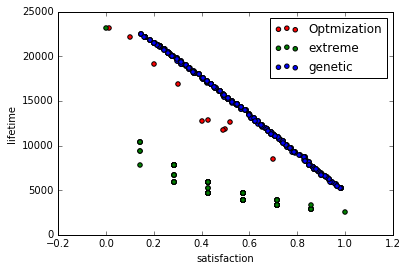

In [15]:
ax = df_final[df_final.method == "optimization"].plot(
    kind="scatter", color="Red",
    x="satisfaction", y="lifetime",
    label="Optmization")

df_final[df_final.method == "extreme"].plot(
    kind="scatter", color="green",
    x="satisfaction", y="lifetime",
    label="extreme", ax=ax)

df_final[df_final.method == "genetic"].plot(
    kind="scatter", color="blue",
    x="satisfaction", y="lifetime",
    label="genetic", ax=ax)

fig = ax.get_figure()
fig.savefig('output.pdf')